# Import appropriate modules

In [118]:
import numpy as np
from numpy.linalg import eigh
from numpy import load
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

import scipy.constants
from scipy.sparse import csgraph

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.gridspec import GridSpec

import mpl_interactions.ipyplot as iplt
from mpl_interactions.controller import Controls

from functools import partial

from tqdm import tqdm, trange

import itertools
import math

from tabulate import tabulate

# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [4]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=2

PULSE_TIME_US = 500 #μs

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}PTime{PULSE_TIME_US}'
print(settings_string)

H_BAR = scipy.constants.hbar
muN = scipy.constants.physical_constants['nuclear magneton'][0]

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*I1)
I2_D = round(2*I2)

D_0 = MOLECULE["d0"]

PER_MN = round((2*I1+1)*(2*I2+1))
N_STATES = PER_MN * (N_MAX+1)**2
print(f"{N_STATES} in molecule")

GAUSS = 1e-4 # T
PULSE_TIME = PULSE_TIME_US * 1e-6 # s

# B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T 

# Load precomputed results

In [5]:
print("Loading precomputed data...")
data = np.load(f'../precomputed/{settings_string}.npz')

B=data['b']
B_MIN = B[0]
B_MAX = B[-1]
B_STEPS = len(B)

ENERGIES = data['energies']
STATES = data['states']

LABELS_D=data['labels_d']
UNCOUPLED_LABELS_D=data['uncoupled_labels_d']

MAGNETIC_MOMENTS=data['magnetic_moments'] 

COUPLINGS_ZERO=data['couplings_zero']
COUPLINGS_MINUS=data['couplings_minus']
COUPLINGS_PLUS=data['couplings_plus']
COUPLINGS = COUPLINGS_ZERO+COUPLINGS_MINUS+COUPLINGS_PLUS
POLARISED_COUPLING = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS]

UNPOLARISED_PAIR_FIDELITIES = data['unpolarised_pair_fidelities_ut']
UNPOLARISED_PAIR_FIDELITIES = UNPOLARISED_PAIR_FIDELITIES + UNPOLARISED_PAIR_FIDELITIES.transpose(1,0,2)
POLARISED_PAIR_FIDELITIES = data['polarised_pair_fidelities_ut']
POLARISED_PAIR_FIDELITIES = POLARISED_PAIR_FIDELITIES + POLARISED_PAIR_FIDELITIES.transpose(1,0,2)
print("Precomuted data loaded.")

# Helper Functions

In [6]:
def label_to_state_no(N,MF_D,k):
    return np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0]

def state_no_to_uncoupled_label(state_no):
    return UNCOUPLED_LABELS_D[state_no]

In [7]:
def label_d_to_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return f"({n},{mf_d//2},{i})"
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return f"({n},{mf_whole}.5,{i})"

def label_d_to_latex_string(label_d):
    n = label_d[0]
    mf_d = label_d[1]
    mf_frac = mf_d%2
    i = label_d[2]
    if mf_frac == 0:
        return r'|{},{}\rangle_{{{}}}'.format(n,mf_d//2,i)
    else:
        mf_whole= (mf_d - np.sign(mf_d))//2
        return r'|{},{}.5\rangle_{{{}}}'.format(n,mf_whole,i)

In [8]:
def label_degeneracy(N,MF_D):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1_D in range(-I1_D,I1_D+1,2):
            for M_I2_D in range(-I2_D,I2_D+1,2):
                if 2*MN+M_I1_D+M_I2_D == MF_D:
                    d+=1
    return d

In [9]:
def reachable_above_from(N,MF_D):
    sigma_plus_reachable = [(N+1,MF_D-2,i) for i in range(label_degeneracy(N+1,MF_D-2))]
    pi_reachable = [(N+1,MF_D,i) for i in range(label_degeneracy(N+1,MF_D))]
    sigma_minus_reachable = [(N+1,MF_D+2,i) for i in range(label_degeneracy(N+1,MF_D+2))]
    return (sigma_plus_reachable + pi_reachable + sigma_minus_reachable)

def twice_average_fidelity(k,g):
    return ((1 + g**2)**2 + 8*k**2*(-1 + 2*g**2) + 16*k**4)/((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)

def maximum_fidelity(k,g):
    phi = np.arccos((k*(18-9*g**2-8*k**2))/(3+3*g**2+4*k**2)**(3/2))/3
    denominator = 54*((1+g**2)**3+(-8+20*g**2+g**4)*k**2+16*k**4)
    numerator = (
                 36*(g**4+(1-4*k**2)**2+2*g**2*(1+8*k**2))
               + 32*k    *(3+3*g**2+4*k**2)**(3/2) *np.cos(phi)
               - 64*k**2 *(3+3*g**2+4*k**2)        *np.cos(2*phi) 
               -  4      *(3+3*g**2+4*k**2)**2     *np.cos(4*phi)
                )
    return numerator/denominator

def fidelity(ts,d=8):
    return -np.log10(1-ts+10**(-d))

In [10]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def field_to_bi(gauss):
    return find_nearest(B,gauss*GAUSS)

In [11]:
INITIAL_STATE_LABELS_D = MOLECULE["StartStates_D"]
INITIAL_STATE_INDICES = [label_to_state_no(*label_d) for label_d in INITIAL_STATE_LABELS_D]
N_INITIAL_STATES = len(INITIAL_STATE_INDICES)

# Zeeman Plot

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:693: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:833: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/text.py:693: ComplexWarning: Casting complex val

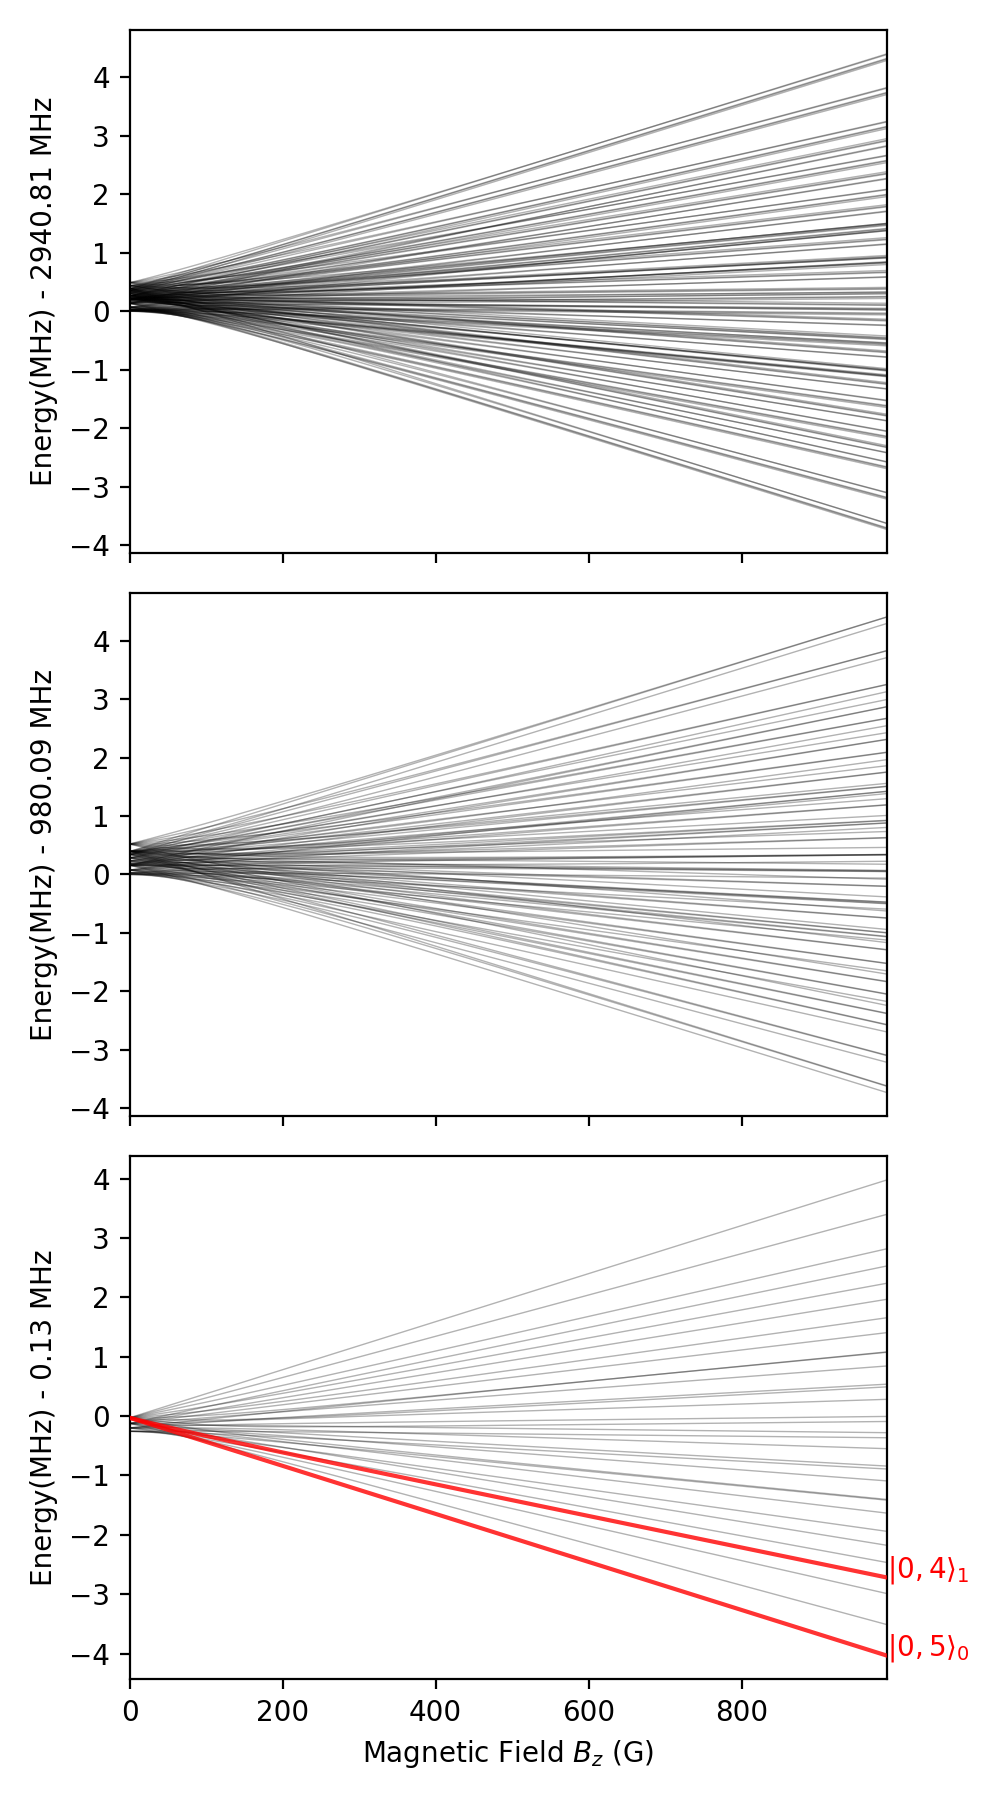

In [12]:
print("plotting zeeman diagram...")
fig, axs = plt.subplots(3,1,figsize=(5,9),sharex = True)

axs[0].set_xlim(0,B_MAX/GAUSS)
axs[-1].set_xlabel('Magnetic Field $B_z$ (G)')

N=N_MAX
for ax in axs:
    base_energy = np.abs(ENERGIES[0,PER_MN*(N)**2]/(scipy.constants.h*1e6))
    ax.set_ylabel(f'Energy(MHz) - {base_energy:.2f} MHz')
    for si in range(PER_MN*(N)**2,PER_MN*(N+1)**2):
        if si in INITIAL_STATE_INDICES:
            ax.plot(B/GAUSS,ENERGIES[:,si]/(scipy.constants.h*1e6)-base_energy,c='red',lw=1.5, alpha=0.8,zorder=10)
            ax.text(B[-1]/GAUSS,ENERGIES[-1,si]/(scipy.constants.h*1e6)-base_energy,f"${label_d_to_latex_string(LABELS_D[si])}$",c='red')
        else:
            ax.plot(B/GAUSS,ENERGIES[:,si]/(scipy.constants.h*1e6)-base_energy,c='black',lw=0.5, alpha=0.3,zorder=1)
    N-=1

fig.savefig(f'../images/many-molecules/{MOLECULE_STRING}-zeeman.pdf')

# Magnetic moments plot

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


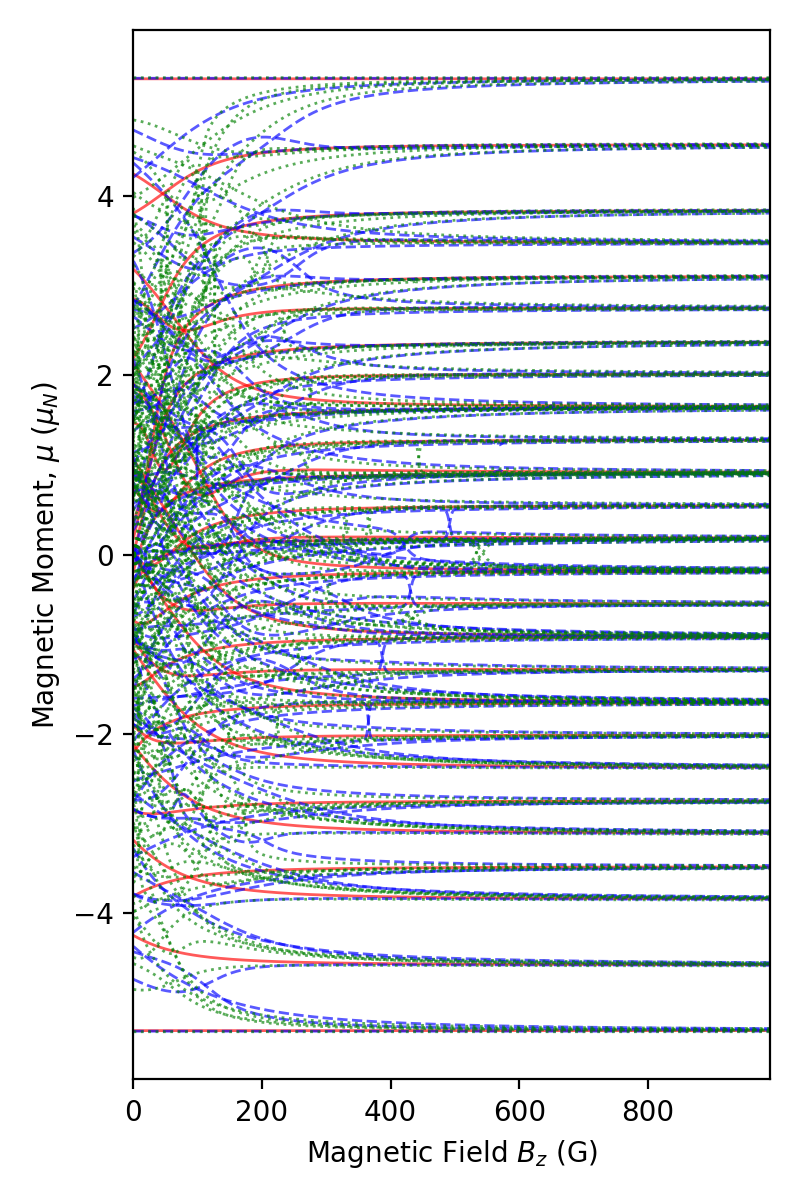

In [13]:
print("plotting magnetic moments...")
fig, ax = plt.subplots(figsize=(4,6))

ax.set_xlim(0,B_MAX/GAUSS)
ax.set_xlabel('Magnetic Field $B_z$ (G)')
ax.set_ylabel('Magnetic Moment, $\mu$ $(\mu_N)$')

states_to_plot = []
for N in range(0,3):
    Fd = 2*N + I1_D + I2_D
    for MF_D in range(-Fd,Fd+1,2):
        for di in range(label_degeneracy(N,MF_D)):
            states_to_plot.append((N,MF_D,di))

for state_label in states_to_plot:
    lw=1
    col = 'red'
    ls = 'solid'
    if state_label[0] == 1:
        ls = 'dashed'
        col='blue'
        lw=1
    if state_label[0] == 2:
        ls = 'dotted'
        col='green'
        lw=1
    
    index = label_to_state_no(*state_label)
    ax.plot(B/GAUSS, MAGNETIC_MOMENTS[:,index]/muN,linestyle=ls, color=col, alpha=0.65,linewidth=lw);

# fig.savefig('../images/3-level-qubit-all-coincidences')

# Find best state Pi-pulse paths

In [14]:
cumulative_fidelity_from_initials = np.zeros((B_STEPS,N_INITIAL_STATES,N_STATES))
predecessor_fidelity_from_initials = np.zeros((B_STEPS,N_INITIAL_STATES,N_STATES),dtype=int)

for bi in range(B_STEPS):
    considered_matrix = UNPOLARISED_PAIR_FIDELITIES[:,:,bi]
    sparse_graph = csgraph.csgraph_from_dense(-np.log(considered_matrix), null_value=np.inf) # Expecting div 0 warning, this is fine
    (distances_from_initials),(predecessors_from_initials) = csgraph.shortest_path(sparse_graph,return_predecessors=True,directed=False,indices=INITIAL_STATE_INDICES)
    
    cumulative_fidelity_from_initials[bi]=distances_from_initials
    predecessor_fidelity_from_initials[bi]=predecessors_from_initials

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_9295/3787961259.py:6: RuntimeWarning: divide by zero encountered in log
  sparse_graph = csgraph.csgraph_from_dense(-np.log(considered_matrix), null_value=np.inf) # Expecting div 0 warning, this is fine


In [15]:
CUTOFF_DISTANCE = 0.99
CUTOFF_BI = 100
from pyvis.network import Network
net = Network(height="1000px",width="75%",directed=False,notebook=True,cdn_resources='in_line',neighborhood_highlight=False,layout=None,filter_menu=False)
# net.repulsion()

edges = set()

cm = matplotlib.cm.get_cmap('Spectral')
colours = cm(np.linspace(0,1,N_INITIAL_STATES))
colours_hex = [matplotlib.colors.to_hex(c, keep_alpha=False) for c in colours]


for si in range(N_STATES):
    ssi = np.argmax(np.exp(-cumulative_fidelity_from_initials[CUTOFF_BI,:,si]))
    fid = np.exp(-cumulative_fidelity_from_initials[CUTOFF_BI,ssi,si])
    if fid > CUTOFF_DISTANCE: # Use me
        # Build tree
        current_back = si
        current_back_label = LABELS_D[si]
        start_index = INITIAL_STATE_INDICES[ssi]
        start_label = LABELS_D[start_index]
        predecessor_list = predecessor_fidelity_from_initials[CUTOFF_BI, ssi,:]
        
        # path = [current_back]
        # states.add(current_back)

        this_y=((fid-CUTOFF_DISTANCE)/(1-CUTOFF_DISTANCE))
        this_x=float(
            (
                current_back_label[1]-start_label[1]
                + current_back_label[2]/label_degeneracy(current_back_label[0],current_back_label[1])
            )*0.05)*(1-this_y)**(0.1) + ssi
        while current_back != start_index:
            next_back = predecessor_list[current_back]
            next_back_label = LABELS_D[next_back]
            edges.add((current_back,next_back))
            current_back = next_back
            current_back_label = next_back_label
    
        state_label = LABELS_D[si]
        label_string = label_d_to_string(state_label)
        net.add_node(int(si),label=label_d_to_string(LABELS_D[si]),x=this_x*2000,y=this_y*2000, value=float(fidelity(fid,d=5)),color=colours_hex[ssi],title=f"{label_string}, cumulative fidelity={fid}",physics=False)
        
    
pcol = ['blue','red','green']
for s,t in edges:
    fid = float(UNPOLARISED_PAIR_FIDELITIES[s,t,CUTOFF_BI])
    from_i = int(t)
    to_i = int(s)
    P = round((LABELS_D[from_i][1] - LABELS_D[to_i][1])*(LABELS_D[from_i][0] - LABELS_D[to_i][0])/2)
    ecol = pcol[P]
    net.add_edge(int(t),int(s), value=fidelity(fid,d=5),arrowStrikethrough=False,color=ecol,title=f"{fid}",physics=True)
    

            

# net.prep_notebook()
# net.show_buttons(filter_=['physics'])
net.toggle_physics(False)
net.show('test.html')

# Optimise 2-level

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


0.6075544233324547


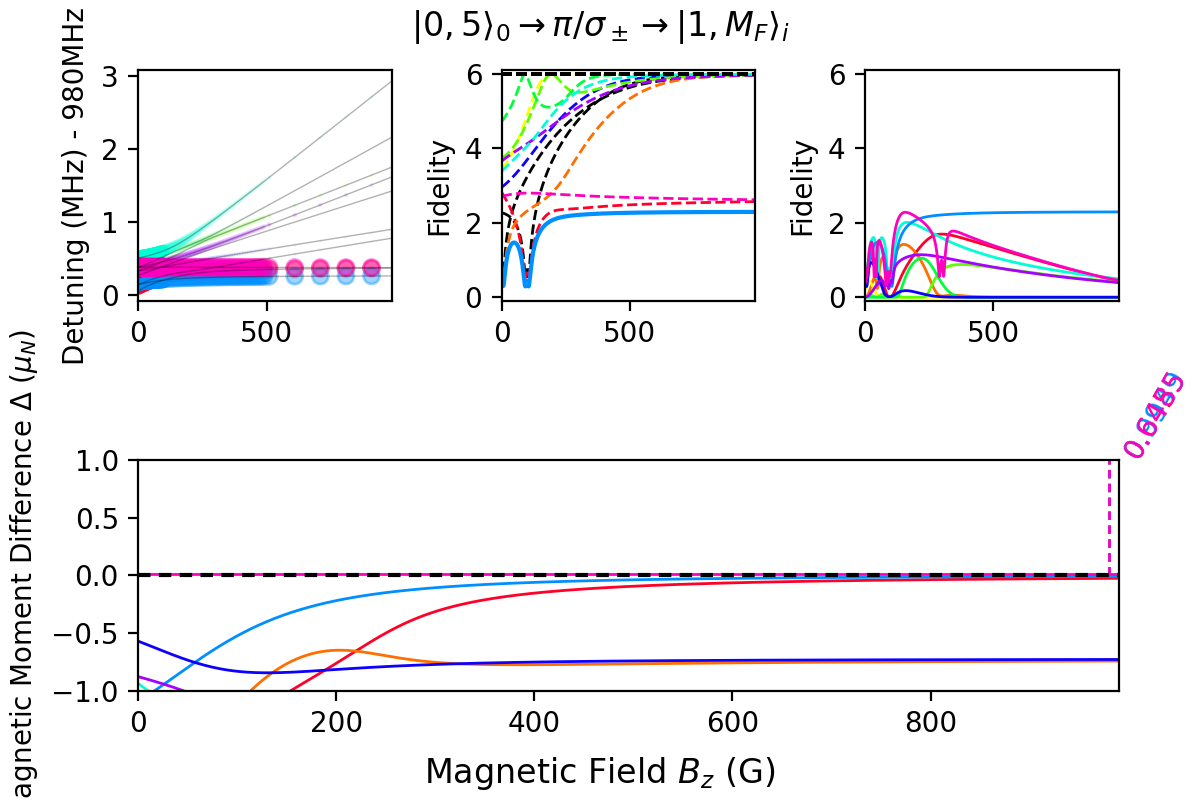

In [96]:
polarisation = None             # Polarisation: -1,0,1,None
initial_state_label_d = INITIAL_STATE_LABELS_D[0]   # Which state to go from
focus_state_label_d = (1,initial_state_label_d[1],0)     # Which state to highlight
desired_pulse_time = 100*1e-6   # What desired pulse time (s)
dynamic_range = 6               # What Dynamic range to use for Fidelity
#################################

if polarisation is None:
    coupling = COUPLINGS
    polarisation_text = '\pi/\sigma_\pm'
else:
    coupling = POLARISED_COUPLING[polarisation]
    polarisation_text = ['\pi','\sigma_+','\pi/\sigma_\pm','\sigma_-'][polarisation]

initial_state_index = label_to_state_no(*initial_state_label_d)
focus_state_index = label_to_state_no(*focus_state_label_d)

accessible_state_labels = reachable_above_from(initial_state_label_d[0],initial_state_label_d[1])
accessible_state_indices = [label_to_state_no(*label) for label in accessible_state_labels]
state_cmap = plt.cm.gist_rainbow(np.linspace(0,1,len(accessible_state_labels)))

fig = plt.figure(constrained_layout=True,figsize=(6,4))

gs = GridSpec(2, 3, figure=fig)
axl = fig.add_subplot(gs[0, 0])
axm = fig.add_subplot(gs[0, 1])
axr = fig.add_subplot(gs[0, 2])
axb = fig.add_subplot(gs[1, :])

title_string = fr"${label_d_to_latex_string(initial_state_label_d)} \rightarrow {polarisation_text} \rightarrow |1,M_F\rangle_i $"
fig.suptitle(title_string)

axl.set_xlim(0,B_MAX/GAUSS)
axm.set_xlim(0,B_MAX/GAUSS)
axr.set_xlim(0,B_MAX/GAUSS)

axm.set_ylim(-0.1,dynamic_range+0.1)
axr.set_ylim(-0.1,dynamic_range+0.1)

axl.set_ylabel("Detuning (MHz) - 980MHz")
axm.set_ylabel("Fidelity")
axr.set_ylabel("Fidelity")
fig.supxlabel('Magnetic Field $B_z$ (G)')

# Left zeeman plot
for i, state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    det = ((ENERGIES[:, state_index] - ENERGIES[:, initial_state_index]) / scipy.constants.h)
    absg = np.abs(coupling[:, initial_state_index, state_index])
    axl.scatter(B[::10]/GAUSS, det[::10]/1e6-980, color=this_colour, edgecolors=None, alpha=absg[::10]**0.5*0.5, s=absg[::10] ** 2 * 100, zorder=2)    
    axl.plot(B/GAUSS,det/1e6-980,color='k',linewidth=0.5,zorder=3,alpha=0.3)
    
# Middle single state plot
transfered = np.ones(B_STEPS)
for off_res_index in range(N_STATES):
    if off_res_index == initial_state_index or off_res_index == focus_state_index:
        continue
    this_colour=state_cmap[accessible_state_indices.index(off_res_index)] if off_res_index in accessible_state_indices else 'black'
    for (a,b) in [(initial_state_index,focus_state_index),(focus_state_index,initial_state_index)]:
        k = np.abs((ENERGIES[:, off_res_index] - ENERGIES[:, b]) * desired_pulse_time / scipy.constants.h)
        g = np.abs(coupling[:, a, off_res_index]/coupling[:, a, b])
        sub_transfered = twice_average_fidelity(k,g)
        axm.plot(B/GAUSS,fidelity(sub_transfered, dynamic_range),c=this_colour,linestyle='dashed',linewidth=1)
        transfered *= sub_transfered
axm.plot(B/GAUSS,fidelity(transfered, dynamic_range),c=state_cmap[accessible_state_indices.index(focus_state_index)])
print(transfered[30])
    

# # Right all state plots
accessible_transfered = []
for i, focus_state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    transfered = np.ones(B_STEPS)
    for off_res_index in range(N_STATES):
        if off_res_index == initial_state_index or off_res_index == focus_state_index:
            continue
        for (a,b) in [(initial_state_index,focus_state_index),(focus_state_index,initial_state_index)]:
            k = np.abs((ENERGIES[:, off_res_index] - ENERGIES[:, b]) * desired_pulse_time / scipy.constants.h)
            g = np.abs(coupling[:, a, off_res_index]/coupling[:, a, b])
            sub_transfered = twice_average_fidelity(k,g)
            transfered *= sub_transfered
    accessible_transfered.append(transfered)
    axr.plot(B/GAUSS,fidelity(transfered, dynamic_range),c=this_colour,linewidth=1)
    

axb.set_xlim(0,B_MAX/GAUSS)
axb.set_ylim(-1,1)
# axb.set_xlabel('Magnetic Field $B_z$ (G)')
axb.set_ylabel('Magnetic Moment Difference $\Delta$ $(\mu_N)$')


axb.axhline(0, dashes=(3, 2), color='k', linewidth=1.5, alpha=1, zorder=3)
for i, focus_state_index in enumerate(accessible_state_indices):
    this_colour = state_cmap[i]
    magnetic_moment_difference = (MAGNETIC_MOMENTS[:,focus_state_index]-MAGNETIC_MOMENTS[:,initial_state_index])
    axb.plot(B/GAUSS,magnetic_moment_difference/muN, alpha=1,linewidth=1,zorder=1,c=this_colour)
    abs_magnetic_moment_difference = np.abs(magnetic_moment_difference)
    min_delta = np.argmin(abs_magnetic_moment_difference)
    if abs_magnetic_moment_difference[min_delta]/muN < 0.3:
        this_transferred = accessible_transfered[i][min_delta]
        if this_transferred < 0.5:
            continue
        text_place = B[min_delta]/GAUSS
        line_place = max(min(B[min_delta]/GAUSS,B_MAX/GAUSS*0.99),B_MAX/GAUSS*0.01)
        axb.axvline(line_place,ymin=0.5,color=this_colour,linewidth=1,dashes=(3,2))
        this_transferred = accessible_transfered[i][min_delta]
        this_transferred_string = f"{this_transferred:.4f}"
        axb.text(text_place,1.02,this_transferred_string,rotation=60,c=this_colour)

# fig.savefig('../images/2-level-optimisation')

# Generic Optimisation Routine

In [134]:
def maximise_fid_dev(possibilities,loop=False,plot=True,required_crossing=None,max_bi=B_STEPS,table_len=9,ignore_small_deviation=False,rate_distance=True,latex_table=False,save_name=None,consider_top=25):
    n_comb = len(possibilities)
    n_waves = len(possibilities[0]) - 1 # NOTE: assumes paths are the same length
    print(n_comb, "combinations to consider")
    possibilities_indices = np.array([np.array([label_to_state_no(*label) for label in possibility]) for possibility in possibilities])
    
    distance = np.zeros((B_STEPS, consider_top),dtype=np.double)
    distance_metric = np.zeros((B_STEPS, consider_top),dtype=np.double)
    
    deviation = np.ones((B_STEPS, consider_top),dtype=np.double)
    deviation_metric = np.zeros((B_STEPS, consider_top),dtype=np.double)
    
    unpol_fid = np.zeros((B_STEPS, consider_top),dtype=np.double)
    unpol_fid_metric = np.zeros((B_STEPS, consider_top),dtype=np.double)
    
    pol_fid = np.zeros((B_STEPS, consider_top),dtype=np.double)
    pol_fid_metric = np.zeros((B_STEPS, consider_top),dtype=np.double)
    
    rating = np.zeros((B_STEPS,consider_top),dtype=np.double)
    peak_rating = np.zeros((consider_top),dtype=np.double)
    peak_rating_index = np.zeros((consider_top),dtype=int)
    
    for i, desired_indices in tqdm(enumerate(possibilities_indices),total=n_comb):
        # Find path to get there from initial state
        this_distance = np.exp(-np.min(cumulative_fidelity_from_initials[:,:,desired_indices],axis=(1,2)))
        this_distance_metric = fidelity(this_distance,d=3)/3
        
        # Find best B for minimum dipole deviation
        all_moments = MAGNETIC_MOMENTS[:,desired_indices]
        if required_crossing is not None:
            required_deviation = all_moments[:,required_crossing[0]]-all_moments[:,required_crossing[1]]
            sign_changes = np.where(np.diff(np.sign(required_deviation)))[0]
            mask = np.ones(max_bi, dtype=bool)
            mask[sign_changes] = False
            all_moments[mask,0] = 1e10
        max_moment = np.amax(all_moments,axis=1)
        min_moment = np.amin(all_moments,axis=1)
        this_deviation = np.abs((max_moment - min_moment)/muN)
        this_deviation_metric = -np.log10(this_deviation+1e-3)/3
        
        # Simulate microwave transfers to find fidelity *within structure*
        this_unpol_fid = np.ones(B_STEPS,dtype=np.double)
        this_pol_fid = np.ones(B_STEPS,dtype=np.double)
        for n in range(n_waves):
            this_unpol_fid *= UNPOLARISED_PAIR_FIDELITIES[desired_indices[n],desired_indices[n+1],:]
            this_pol_fid *= POLARISED_PAIR_FIDELITIES[desired_indices[n],desired_indices[n+1],:]
        if loop:
            this_unpol_fid *= UNPOLARISED_PAIR_FIDELITIES[desired_indices[0],desired_indices[-1],:]
            this_pol_fid *= POLARISED_PAIR_FIDELITIES[desired_indices[0],desired_indices[-1],:]
        this_unpol_fid_metric = fidelity(this_unpol_fid,d=3)/3
        this_pol_fid_metric = fidelity(this_pol_fid,d=5)/5
        
        # Rank this combination
        this_rating = this_deviation_metric * this_unpol_fid_metric * this_pol_fid_metric
        if rate_distance:
            this_rating *= this_distance_metric
        
        this_peak_rating = np.max(this_rating)
        better_array = this_peak_rating - peak_rating
        the_worst_index = np.argmax(better_array)
        the_worst_difference = better_array[the_worst_index]
        if the_worst_difference > 0:
            peak_rating[the_worst_index] = this_peak_rating
            peak_rating_index[the_worst_index] = i
            
            distance[:,the_worst_index] = this_distance
            distance_metric[:,the_worst_index] = this_distance_metric
            deviation[:,the_worst_index] = this_deviation
            deviation_metric[:,the_worst_index] = this_deviation_metric
            unpol_fid[:,the_worst_index] = this_unpol_fid
            pol_fid[:,the_worst_index] = this_pol_fid
            unpol_fid_metric[:,the_worst_index] = this_unpol_fid_metric
            pol_fid_metric[:,the_worst_index] = this_pol_fid_metric
        
            rating[:,the_worst_index] = this_rating

    order = (-peak_rating).argsort()
    
    # Display Results
    if plot:
        fig, axs = plt.subplots(3,3,figsize=(9,6),dpi=100,sharex=True,sharey=True,constrained_layout=True)
        axs = axs.flatten()
    headers = ['States', 'B.Field(G)', 'MagDipDev(u)', 'UnPol-Fid', 'Pol-Fid', 'UnPol-Dist','Rating','Path']
    data = []
    for i in range(table_len):
        besti = order[i]
        combi = peak_rating_index[besti]
        state_labels = possibilities[combi]
        state_numbers = np.array([label_to_state_no(*state_label) for state_label in state_labels])
        
        this_rating = rating[:,besti]
        # this_peak_rating = peak_rating[besti]
        peak_rating_bi = np.argmax(this_rating)
        peak_rating = this_rating[peak_rating_bi]
        peak_magnetic_field = B[peak_rating_bi]
        
        this_distance_metric = distance_metric[:,besti]
        this_deviation_metric = deviation_metric[:,besti]
        this_unpol_fid_metric = unpol_fid_metric[:,besti]
        this_pol_fid_metric = pol_fid_metric[:,besti]
        
        if plot and i<9:
            ax = axs[i]
            ax.set_xlim(0,B_MAX/GAUSS)
            ax.set_ylim(0,1.01)

            ax.plot(B/GAUSS, this_distance_metric, linestyle='dashed', c='green', alpha=0.4)
            ax.plot(B/GAUSS, this_deviation_metric, linestyle='dashed', c='blue', alpha=0.4)
            ax.plot(B/GAUSS, this_unpol_fid_metric, linestyle='dotted', c='black', alpha=0.4)
            ax.plot(B/GAUSS, this_pol_fid_metric, linestyle='dotted', c='black', alpha=0.4)
            
            ax.axvline(B[peak_rating_bi]/GAUSS,color='black',linewidth=1,dashes=(3,2))

            ax.plot(B/GAUSS, this_rating, c='red')
            
        peak_distance = distance[peak_rating_bi,besti]
        peak_deviation = deviation[peak_rating_bi,besti]
        peak_unpol_fid = unpol_fid[peak_rating_bi,besti]
        peak_pol_fid = pol_fid[peak_rating_bi,besti]
            
        peak_distance_metric = this_distance_metric[peak_rating_bi]
        peak_deviation_metric = this_deviation_metric[peak_rating_bi]
        peak_unpol_fid_metric = this_unpol_fid_metric[peak_rating_bi]
        peak_pol_fid_metric = this_pol_fid_metric[peak_rating_bi]
        
        # current_back = state_numbers[this_distance_topo_index]
        # start_index = INITIAL_STATE_INDICES[this_distance_initial_index]
        # initial_label = LABELS_D[current_back]
        # predecessor_list = predecessor_fidelity_from_initials[ordered_B[i], this_distance_initial_index,:]
        # path=f"({initial_label[0]},{initial_label[1]},{initial_label[2]})"
        # path = [initial_label]
        # while current_back != start_index:
        #     current_back = predecessor_list[current_back]
        #     path.append(LABELS_D[current_back])
        # if len(path) <= 3:
        #     path_string = "<".join([label_d_to_string(label) for label in path])
        # else:
        #     path_string = "<".join([label_d_to_string(label) for label in path[:1]])
        #     path_string += f"<(+{len(path)-2})<"
        #     path_string += "<".join([label_d_to_string(label) for label in path[len(path)-1:]])
        
        path_string = "---"
        states_string = ",".join([label_d_to_string(label) for label in state_labels])
        string_list = [states_string,
                       f"{peak_magnetic_field/GAUSS:6.1f}",
                       f"{peak_deviation:.3f}u({peak_deviation_metric:.2f})",
                       f"{peak_unpol_fid:.3f}({peak_unpol_fid_metric:.2f})",
                       f"{peak_pol_fid:.3f}({peak_pol_fid_metric:.2f})",
                       f"{peak_distance:.3f}({peak_distance_metric:.2f})",
                       f"{peak_rating:7.4f}",
                       path_string]
        data.append(string_list)
    
    print(tabulate(data, headers=headers,tablefmt="fancy_grid"))
    if latex_table:
        with open(f"../tables/{save_name}.tex", "w") as text_file:
            text_file.write(tabulate(data, headers=headers, tablefmt="latex_raw"))
    if plot:
        fig.supxlabel('Magnetic Field $B_z$ (G)')
        fig.supylabel('Rating Components')
        if save_name is not None:
            fig.savefig(f'../images/many-molecules/{save_name}.pdf')

# Robust Storage Bit Optimisation

In [135]:
print("General Robust Storage Qubit Optimisation")

possibilities = []
for N1 in range(0,N_MAX+1): #[1]:#
    for N2 in [N1-1,N1+1]: #[0]:#
        if N2 < 0 or N2 > N_MAX:
            continue
        F1_D = 2*N1+I1_D+I2_D
        F2_D = 2*N2+I1_D+I2_D
        for MF1_D in range(-F1_D,F1_D+1,2):#[2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
            for p1 in [-1,0,1]:
                for p2 in [-1,0,1]:
                    if MF1_D+2*p1 > F2_D or MF1_D+2*p1 < -F2_D or MF1_D+2*p2 > F2_D or MF1_D+2*p2 < -F2_D:
                        continue
                    MF2a_D = MF1_D+2*p1
                    MF2b_D = MF1_D+2*p2
                    if MF2a_D < MF2b_D:
                        continue
                    for i in range(label_degeneracy(N1,MF1_D)):
                        for j in range(label_degeneracy(N2,MF2a_D)):
                            for k in range(label_degeneracy(N2,MF2b_D)):
                                if MF2a_D == MF2b_D and j <= k:
                                    continue
                                possibilities.append([(N2,MF2a_D,j),(N1,MF1_D,i),(N2,MF2b_D,k)])
possibilities_d = np.array(possibilities)

187984 combinations to consider


100%|█████████████████████████████████| 187984/187984 [00:36<00:00, 5105.84it/s]


╒══════════════════════════╤══════════════╤════════════════╤═════════════╤═════════════╤══════════════╤══════════╤════════╕
│ States                   │   B.Field(G) │ MagDipDev(u)   │ UnPol-Fid   │ Pol-Fid     │ UnPol-Dist   │   Rating │ Path   │
╞══════════════════════════╪══════════════╪════════════════╪═════════════╪═════════════╪══════════════╪══════════╪════════╡
│ (1,5,1),(0,4,0),(1,4,1)  │          322 │ 0.001u(0.89)   │ 0.999(0.89) │ 1.000(0.89) │ 0.983(0.58)  │   0.4137 │ ---    │
├──────────────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (2,6,0),(1,5,0),(2,5,0)  │          970 │ 0.005u(0.74)   │ 0.980(0.56) │ 1.000(1.00) │ 1.000(0.97)  │   0.4051 │ ---    │
├──────────────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (2,6,0),(1,5,0),(2,4,0)  │          630 │ 0.002u(0.86)   │ 0.964(0.48) │ 1.000(1.00) │ 1.000(0.97)  │   0.399  │ ---    │
├───────

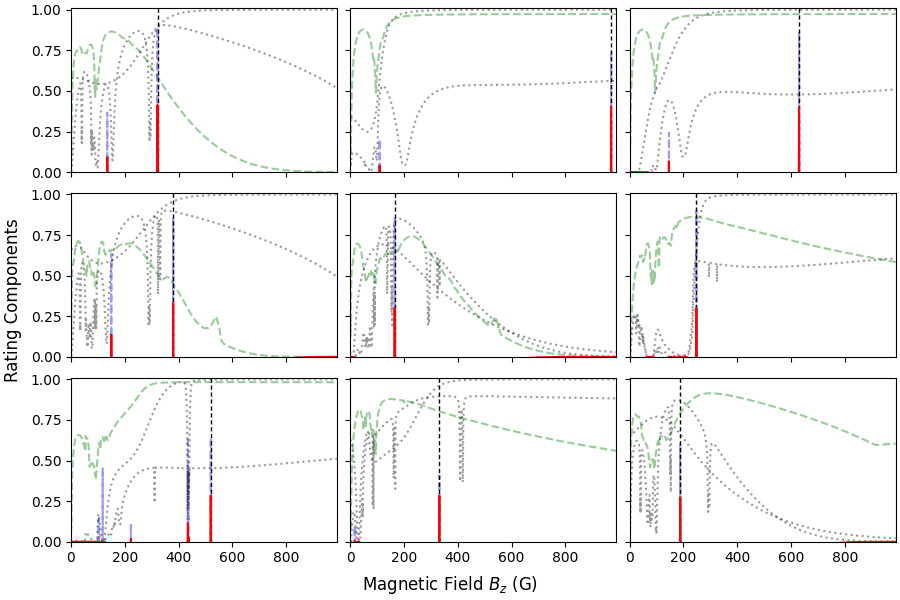

In [136]:
maximise_fid_dev(possibilities_d[:,:],loop=False,required_crossing=[0,2],rate_distance=True,table_len=9,latex_table=True,save_name=f"{MOLECULE_STRING}-qubit")

# Robust Storage Bit in N=0 Optimisation

In [137]:
print("Robust Storage Qubit N=0 Optimisation")

possibilities = []
for N1 in [1]: #range(0,N_MAX+1): #[1]:#
    for N2 in [0]: #[N1-1,N1+1]: #[0]:#
        if N2 < 0 or N2 > N_MAX:
            continue
        F1_D = 2*N1+I1_D+I2_D
        F2_D = 2*N2+I1_D+I2_D
        for MF1_D in range(-F1_D,F1_D+1,2):#[2,3,4,5]+([6] if N1>0 else []):#range(-F1,F1+1,1):
            for p1 in [-1,0,1]:
                for p2 in [-1,0,1]:
                    if MF1_D+2*p1 > F2_D or MF1_D+2*p1 < -F2_D or MF1_D+2*p2 > F2_D or MF1_D+2*p2 < -F2_D:
                        continue
                    MF2a_D = MF1_D+2*p1
                    MF2b_D = MF1_D+2*p2
                    if MF2a_D < MF2b_D:
                        continue
                    for i in range(label_degeneracy(N1,MF1_D)):
                        for j in range(label_degeneracy(N2,MF2a_D)):
                            for k in range(label_degeneracy(N2,MF2b_D)):
                                if MF2a_D == MF2b_D and j <= k:
                                    continue
                                possibilities.append([(N2,MF2a_D,j),(N1,MF1_D,i),(N2,MF2b_D,k)])
possibilities_d = np.array(possibilities)

4432 combinations to consider


100%|█████████████████████████████████████| 4432/4432 [00:00<00:00, 4977.29it/s]


╒═══════════════════════════╤══════════════╤════════════════╤═════════════╤═════════════╤══════════════╤══════════╤════════╕
│ States                    │   B.Field(G) │ MagDipDev(u)   │ UnPol-Fid   │ Pol-Fid     │ UnPol-Dist   │   Rating │ Path   │
╞═══════════════════════════╪══════════════╪════════════════╪═════════════╪═════════════╪══════════════╪══════════╪════════╡
│ (0,4,1),(1,4,5),(0,4,0)   │         45.5 │ 0.024u(0.54)   │ 0.990(0.65) │ 0.999(0.62) │ 1.000(1.00)  │   0.2175 │ ---    │
├───────────────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (0,1,3),(1,0,8),(0,0,2)   │        171   │ 0.004u(0.77)   │ 0.973(0.52) │ 0.999(0.60) │ 0.992(0.69)  │   0.1666 │ ---    │
├───────────────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (0,2,3),(1,1,8),(0,1,2)   │        176   │ 0.056u(0.41)   │ 0.978(0.55) │ 0.999(0.57) │ 0.999(0.90)  │   0.1167 │ ---    │


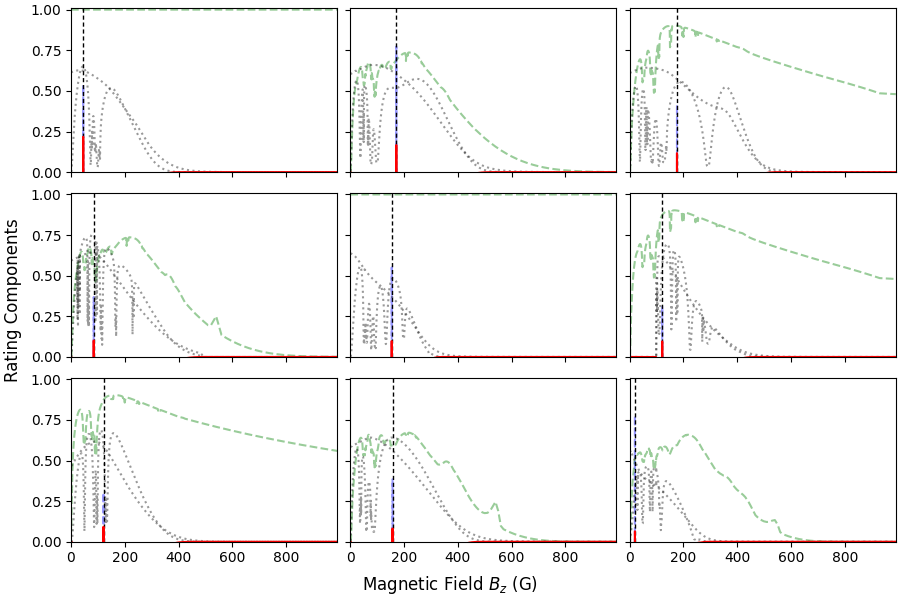

In [139]:
maximise_fid_dev(possibilities_d[:,:],loop=False,required_crossing=[0,2],rate_distance=True,table_len=9,latex_table=True,save_name=f"{MOLECULE_STRING}-qubit-zero")

# 4-state loop Optimisation

In [105]:
print("4-state loop optimisation")

# Find all possible combinations
polarisations = []
for p1 in [-1,0,1]:
    for p2 in [-1,0,1]:
        for p3 in [-1,0,1]:
            for p4 in [-1,0,1]:
                if p1+p2+p3+p4 == 0:
                    polarisations.append((p1,p2,p3,p4))

state_mfs = []            
F1_D = I1_D+I2_D
for base_mf_d in range(-F1_D,F1_D+1,2):
    for p1,p2,p3,_ in polarisations:
        state_mfs.append((base_mf_d,base_mf_d+2*p1,base_mf_d+2*p1+2*p2,base_mf_d+2*p1+2*p2+2*p3))

states = []
for state_mf in state_mfs:
    for i in range(label_degeneracy(0,state_mf[0])):
        for j in range(label_degeneracy(1,state_mf[1])):
            for k in range(label_degeneracy(2,state_mf[2])):
                for l in range(label_degeneracy(1,state_mf[3])):
                    if (state_mf[1]<state_mf[3]) or (state_mf[1]==state_mf[3] and j<=l):
                        continue
                    states.append([(0,state_mf[0],i),(1,state_mf[1],j),(2,state_mf[2],k),(1,state_mf[3],l)])
                    
states=np.array(states)

504014 combinations to consider
╒═════════════════════════════════╤══════════════╤════════════════╤═════════════╤═════════════╤══════════════╤══════════╤════════╕
│ States                          │   B.Field(G) │ MagDipDev(u)   │ UnPol-Fid   │ Pol-Fid     │ UnPol-Dist   │   Rating │ Path   │
╞═════════════════════════════════╪══════════════╪════════════════╪═════════════╪═════════════╪══════════════╪══════════╪════════╡
│ (0,5,0),(1,6,0),(2,6,0),(1,5,0) │          840 │ 0.020u(0.56)   │ 0.971(0.51) │ 1.000(1.00) │ 1.000(1.00)  │   0.2843 │ ---    │
├─────────────────────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (0,4,1),(1,5,2),(2,5,3),(1,4,3) │          840 │ 0.021u(0.56)   │ 0.972(0.51) │ 1.000(1.00) │ 1.000(1.00)  │   0.2837 │ ---    │
├─────────────────────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (0,4,1),(1,5,2),(2,4,3),(1,4,3) │          740 │ 

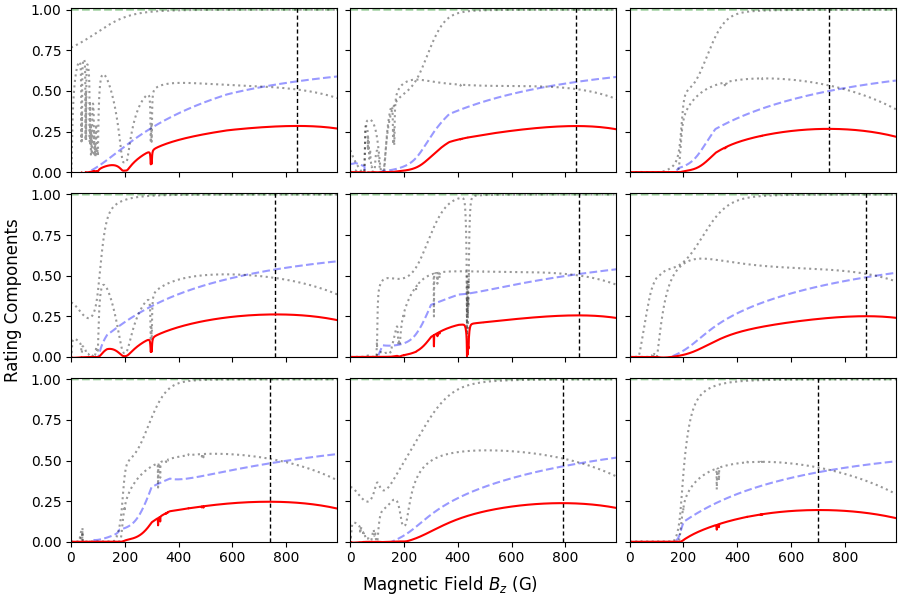

In [106]:
maximise_fid_dev(states,loop=True,table_len=9,rate_distance=True,latex_table=True,save_name=f"{MOLECULE_STRING}-4-state")

# 2-state

In [107]:
print("2-state optimisation")

states=[]
for N1 in range(0,N_MAX): #[1]:#
    N2=N1+1
    F1_D = 2*N1+I1_D+I2_D
    for MF1_D in range(-F1_D,F1_D+1,2):
        for MF2_D in [MF1_D-2,MF1_D,MF1_D+2]:
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2_D)):
                    states.append([(N1,MF1_D,i),(N2,MF2_D,j)])           
states=np.array(states)

5300 combinations to consider
╒═════════════════╤══════════════╤════════════════╤═════════════╤═════════════╤══════════════╤══════════╤════════╕
│ States          │   B.Field(G) │ MagDipDev(u)   │ UnPol-Fid   │ Pol-Fid     │ UnPol-Dist   │   Rating │ Path   │
╞═════════════════╪══════════════╪════════════════╪═════════════╪═════════════╪══════════════╪══════════╪════════╡
│ (0,4,1),(1,4,3) │          368 │ 0.000u(1.00)   │ 1.000(0.98) │ 1.000(0.97) │ 1.000(1.00)  │   0.9499 │ ---    │
├─────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (0,3,2),(1,3,6) │          201 │ 0.000u(0.95)   │ 0.999(0.93) │ 1.000(0.93) │ 0.887(0.89)  │   0.7277 │ ---    │
├─────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (1,5,1),(2,6,1) │          192 │ 0.000u(0.98)   │ 1.000(0.99) │ 1.000(0.98) │ 0.753(0.75)  │   0.7188 │ ---    │
├─────────────────┼──────────────┼────────────────

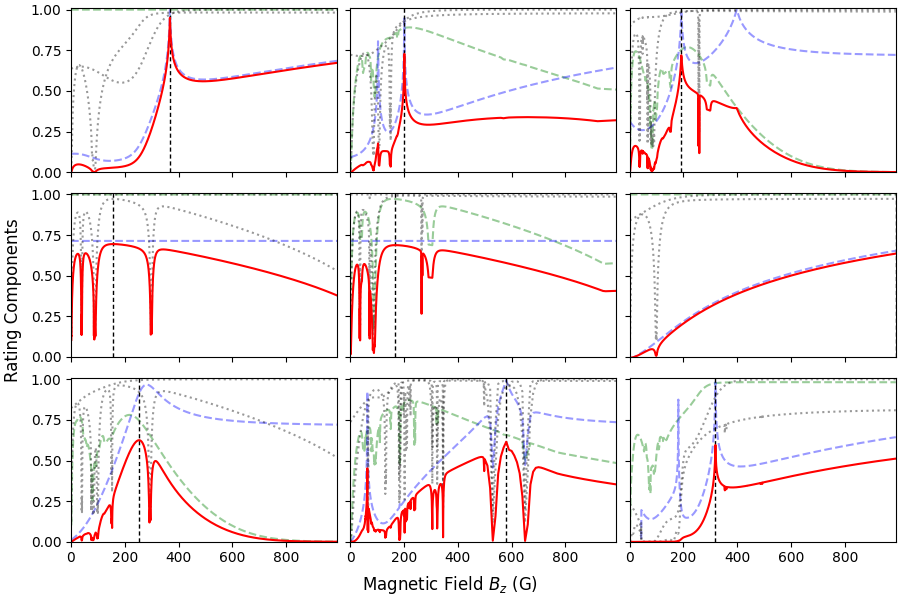

In [108]:
maximise_fid_dev(states,table_len=9,rate_distance=True,ignore_small_deviation=True,latex_table=True,save_name=f"{MOLECULE_STRING}-2-state")


# 3-state

In [140]:
print("3-state optimisation")

states=[]
N1=0
N2=1
N3=2
F1_D = 2*N1+I1_D+I2_D
for MF1_D in range(-F1_D,F1_D+1,2):
    for MF2_D in [MF1_D-2,MF1_D,MF1_D+2]:
        for MF3_D in [MF2_D-2,MF2_D,MF2_D+2]:
            for i in range(label_degeneracy(N1,MF1_D)):
                for j in range(label_degeneracy(N2,MF2_D)):
                    for k in range(label_degeneracy(N3,MF3_D)):
                        states.append([(N1,MF1_D,i),(N2,MF2_D,j),(N3,MF3_D,k)])           
states=np.array(states)

3-state optimisation


45744 combinations to consider
╒═════════════════════════╤══════════════╤════════════════╤═════════════╤═════════════╤══════════════╤══════════╤════════╕
│ States                  │   B.Field(G) │ MagDipDev(u)   │ UnPol-Fid   │ Pol-Fid     │ UnPol-Dist   │   Rating │ Path   │
╞═════════════════════════╪══════════════╪════════════════╪═════════════╪═════════════╪══════════════╪══════════╪════════╡
│ (0,5,0),(1,6,0),(2,7,0) │          167 │ 0.012u(0.62)   │ 1.000(0.96) │ 1.000(1.00) │ 1.000(1.00)  │   0.6024 │ ---    │
├─────────────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (0,3,0),(1,4,2),(2,5,2) │          165 │ 0.001u(0.92)   │ 1.000(0.95) │ 1.000(0.92) │ 0.647(0.65)  │   0.5232 │ ---    │
├─────────────────────────┼──────────────┼────────────────┼─────────────┼─────────────┼──────────────┼──────────┼────────┤
│ (0,4,0),(1,5,1),(2,6,1) │          212 │ 0.006u(0.72)   │ 1.000(0.95) │ 1.000(0.98) │ 0.780(0.78)  │   0.5

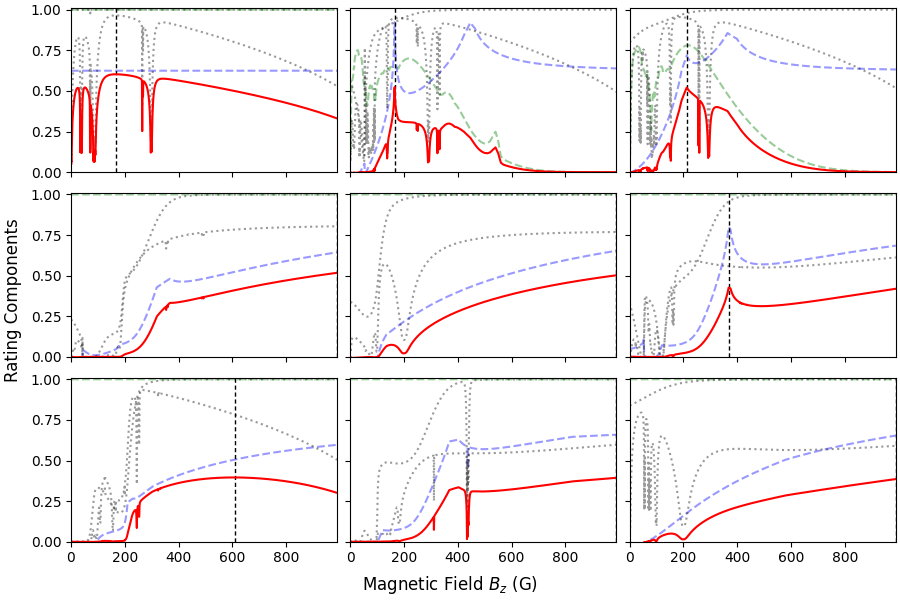

In [112]:
maximise_fid_dev(states,table_len=9,latex_table=True,rate_distance=True,save_name=f"{MOLECULE_STRING}-3-state")